# Load data

In [1]:
from utils.prepare_data import getMonitoredPatients

patients = getMonitoredPatients()

In [ ]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Define model

In [7]:
import xgboost as xgb

how = "last"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## Without validate

### Without fill missing data (BEST)

/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:30:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:30:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/e

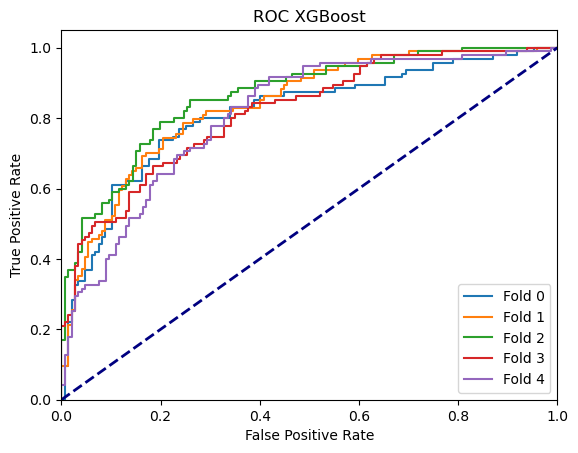

In [8]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from utils.prepare_data import normalizeData, trainTestPatients
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import pandas as pd


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

plt.figure()
for i, (trainPatients, testPatients) in enumerate(trainTestPatients(patients)):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))
    auc_pr_list.append(auc(recall_vals, precision_vals))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"Fold {i}")

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC XGBoost")
plt.legend(loc="lower right")
plt.show()

In [9]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8278492458819112 +- 0.019861509964791857 [0.8128177586824203, 0.8377478651034882, 0.862364816149964, 0.8167267483777938, 0.8095890410958905]
Accuracy: 0.7520661157024794 +- 0.014577108148174504 [0.7603305785123967, 0.7634854771784232, 0.7676348547717843, 0.7344398340248963, 0.7344398340248963]
Specificity: 0.8360916969527536 +- 0.03133710889194877 [0.8503401360544217, 0.8027210884353742, 0.863013698630137, 0.8698630136986302, 0.7945205479452054]
Precision: 0.7129869396721447 +- 0.02709826515320617 [0.7283950617283951, 0.6947368421052632, 0.7468354430379747, 0.7246376811594203, 0.6703296703296703]
Recall: 0.6225307950727883 +- 0.05653409215045079 [0.6210526315789474, 0.7021276595744681, 0.6210526315789474, 0.5263157894736842, 0.6421052631578947]
AUC PR: 0.7634522521835392 +- 0.035083956126559374 [0.7311725980506187, 0.768733657612679, 0.821146882228874, 0.7734491431204692, 0.7227589799050547]


### Fill missing with knn

In [10]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTestPatients(patients):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:32:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/xgboost

In [11]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8117784301282832
Average Accuracy: 0.7412914509104626
Average Precision: 0.6970314513073133
Average Recall: 0.6097872340425532


## With validate

### Without fill missing data

In [ ]:
from utils.prepare_data import normalizeData, trainValTestPatients


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainValGen, testPatients in trainValTestPatients(patients):
    for trainPatients, valPatients in trainValGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
        y_val = dfVal[labelColumn]  # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        model = createModel()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

        accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
        precision_score_list_val.append(precision_score(y_test, y_pred))
        recall_score_list_val.append(recall_score(y_test, y_pred))
        auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

In [ ]:
print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

### Fill missing with knn 

In [ ]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainValGen, testPatients in trainValTestPatients(patients):
    for trainPatients, valPatients in trainValGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6),
            pd.Timedelta(hours=24),
            how,
            getUntilAkiPositive=True,
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
        y_val = dfVal[labelColumn]  # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        model = createModel()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

        accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
        precision_score_list_val_knn.append(precision_score(y_test, y_pred))
        recall_score_list_val_knn.append(recall_score(y_test, y_pred))
        auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

In [ ]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

# Explain

<Axes: >

<Figure size 3000x3000 with 0 Axes>

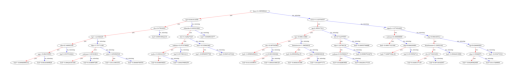

In [12]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

In [13]:
from shap import TreeExplainer
import shap
shap.initjs()

/media/data3/users/tubh/micromamba/envs/python11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


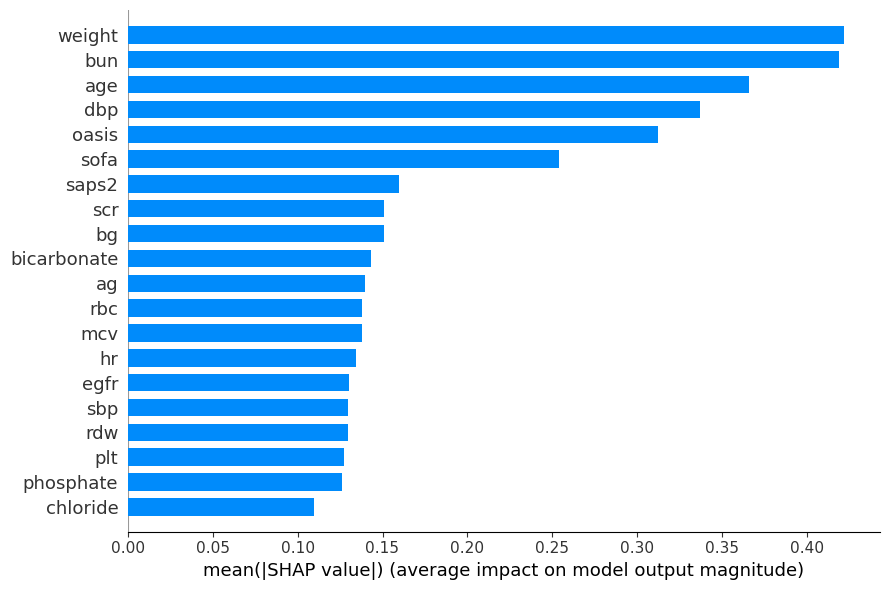

In [14]:
from constants import TEMP_PATH


expl = TreeExplainer(model)
shap_values = expl(X_test)

shap.summary_plot(shap_values, plot_type="bar", show=False, plot_size=[9, 6])
plt.savefig(TEMP_PATH / "shap_xgboost_summary_plot.svg", format="svg")
plt.show()

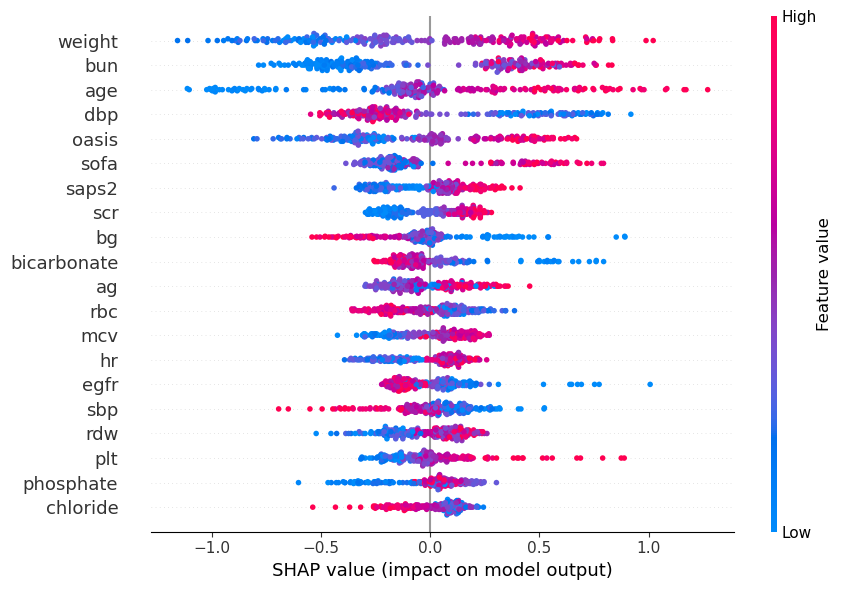

In [15]:
shap.summary_plot(shap_values, show=False, plot_size=[9, 6])
plt.savefig(TEMP_PATH / "shap_xgboost_beeswarm.svg", format="svg")
plt.show()